In [1]:
import random
from numpy.random import seed
seed(3)
import numpy as np
np.random.default_rng
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from os.path import expanduser as ospath
import os
os.chdir("C:/Users/rober/project/B_Data_pre_processing/My_functions")
from C_metrics_binary import calc_binary_class_metrics
from E_MAEweighted_funct import MAE_weighted
os.chdir("C:/Users/rober/project/F_Extra_Experiments_Abstracts/")

import xgboost as xgb
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold,GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter

## Steps:

> 1. Load pre-processed text
> 2. Split in three datasets and divide the features from the targets
> 3. Word representation using TF-IDF 
> 4. Using SMOTE to Balanced the train data
> 5. Train the two best learning algorithms - Random Forest and XGBoost


        First algorithm Random Forest:
        
>>        5.1 Train anduntuned test Random Forest and TF-IDF both 
>>        5.2 Tune TF-IDF
>>        5.3 Train and test Random Forest with only TF-IDF tuned
>>        5.4 Tune hyperparameters Random Forest
>>        5.5 Train and test Random Forest with TF-IDF both tuned
        
        Second algorithm XGBoost:
        
>>        5.6 Train and test XGBoost and TF-IDF both untuned
>>        5.7 Tune TF-IDF
>>        5.8 Train and test XGBoost with only TF-IDF tuned
>>        5.9 Tune hyperparameters XGBoost
>>        5.10 Train and test XGBoost with TF-IDF both tuned
        
> 6. Best model    

***

# 1. Load pre-processed text


In [2]:
with open(ospath('~/code_final_project/B_Data_pre_processing/Pickle_Files/Claims_cleaned.pickle'), 'rb') as data:
    db = pickle.load(data)

In [3]:
db.head()

,publn_nr,type,label,text,text_clean
1,4254843,Claim 1,product,An electrically powered vehicle comprising: a ...,electrically power vehicle comprise body suppo...
2,4254843,Claim 2,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim wherei...
3,4254843,Claim 3,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim wherei...
4,4254843,Claim 4,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim compri...
5,4254843,Claim 5,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim compri...


This convert name labels form string to numbers and merge into only two classes 

In [4]:
db['label'] = db.label.replace(to_replace=['product', 'process', 'use claim', 'product and process'], value=[1, 0, 0,1])
db.groupby(by='label').count()

,publn_nr,type,text,text_clean
label,,,,
0,1047,1047,1047,1047
1,3810,3810,3810,3810


***

# 2. Split in three datasets and divide the features from the targets

Train 50%, validation 25% and test 25% datasets. 


In [5]:
def split_train_test_val(db):
    
    random.seed(0)
    pat_nr = list(db['publn_nr'].unique())
    print('number of patents :',str(len(pat_nr )))
    
    test =  random.sample(pat_nr, 48)

    train_test = [i for i in pat_nr if i not in test]

    val = random.sample(train_test, 48)

    train = [i for i in train_test if i not in val]

    #create an empty data set
    train_db = pd.DataFrame()                             
    for num in range(len(train)):   
        train_db = train_db.append(db.loc[db['publn_nr'] == train[num]], ignore_index=True)

    #create an empty data set
    val_db = pd.DataFrame()                             
    for num in range(len(val)):   
        val_db = val_db.append(db.loc[db['publn_nr'] == val[num]], ignore_index=True)

    #create an empty data set
    test_db = pd.DataFrame()                             
    for num in range(len(test)):   
        test_db = test_db.append(db.loc[db['publn_nr'] == test[num]], ignore_index=True)

    print('-'*80,'\n')
    print('Train data:')
    print('Train data shape: {} \nNumber of patents: {}'.format(train_db.shape ,len(train_db['publn_nr'].unique())))
    print('First patent number train:',train_db['publn_nr'].iloc[0])
    print()
    print('Train frequency classes:',train_db.groupby(by='label').count().iloc[:,:1])
    print('-'*80,'\n')
    print('Test data:')
    print('Test data shape: {} \nNumber of patents: {}'.format(test_db.shape, len(test_db['publn_nr'].unique())))
    print('First patent number test:',test_db['publn_nr'].iloc[0])
    print()
    print('Test frequency classes:',test_db.groupby(by='label').count().iloc[:,:1])
    print('-'*80,'\n')
    print('Val data:')
    print('Val data shape: {} \nNumber of patents: {}'.format(val_db.shape, len(val_db['publn_nr'].unique())))
    print('First patent number val:',val_db['publn_nr'].iloc[0])
    print()
    print('Val frequency classes:',val_db.groupby(by='label').count().iloc[:,:1],'\n')
    
    
    return train_db, test_db, val_db

train_db, test_db, val_db = split_train_test_val(db) 


number of patents : 194
-------------------------------------------------------------------------------- 

Train data:
Train data shape: (2570, 5) 
Number of patents: 98
First patent number train: 5680032

Train frequency classes:        publn_nr
label          
0           567
1          2003
-------------------------------------------------------------------------------- 

Test data:
Test data shape: (1205, 5) 
Number of patents: 48
First patent number test: 1353191

Test frequency classes:        publn_nr
label          
0           312
1           893
-------------------------------------------------------------------------------- 

Val data:
Val data shape: (1082, 5) 
Number of patents: 48
First patent number val: 7061749

Val frequency classes:        publn_nr
label          
0           168
1           914 



### Separate for the three datasets the features from the labels

In [6]:
X_train = train_db['text_clean']
y_train = train_db['label']

X_val = val_db['text_clean']
y_val = val_db['label']

X_test = test_db['text_clean']
y_test = test_db['label']

y_train = y_train.astype('int')
y_val = y_val.astype('int')
y_test = y_test.astype('int')

Initialisation dataset to store all the results

In [7]:
results_score = pd.DataFrame()

***

# 3. Word representation using TF-IDF
At the first, I do not select the features dimension. I run the model with all the features. I use the same TF-IDF vectorizer below for the second untuned learning algorithm - XGBoost. 

In [8]:
tfidf = TfidfVectorizer(ngram_range = (1,2), encoding='utf-8', sublinear_tf = True)

X_train_tf = tfidf.fit_transform(X_train).toarray()
X_test_tf = tfidf.transform(X_test).toarray()
X_val_tf = tfidf.transform(X_val).toarray()


y_train = y_train.astype('int')
y_test = y_test.astype('int')
y_val = y_val.astype('int')

***

# 4. Using SMOTE to Balanced the train data

In [9]:
balance = SMOTE()
X_train_bal, y_train_bal = balance.fit_resample(X_train_tf, y_train)

***

# 5. Train the two best learning algorithms - Random Forest and XGBoost

## 5.1 Train and test Random Forest and TF-IDF both untuned


### First random forest model without any tuning and no feature dimension selected.

Train and evaluate the model with validation data. 

In [10]:
random.seed(2)
rf = RandomForestClassifier(random_state = 8, n_jobs = -1)
rf.fit(X_train_bal, y_train_bal)
rf_pred = rf.predict(X_val_tf)

print("Accuracy on validation data: \n",metrics.accuracy_score(y_val, rf_pred))
print("Classification report: \n",metrics.classification_report(y_val, rf_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val, rf_pred)))




Accuracy on validation data: 
 0.9713493530499075
Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.85      0.90       168
           1       0.97      0.99      0.98       914

    accuracy                           0.97      1082
   macro avg       0.97      0.92      0.94      1082
weighted avg       0.97      0.97      0.97      1082

Confusion Matrix validation: 
[[143  25]
 [  6 908]]


In [11]:
sc = calc_binary_class_metrics(y_val, rf_pred, 'RF not tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973205,0.993435,0.85119,0.983216,0.971349,0.922313,0.922313


In [12]:
random.seed(2)
rf_pred_test = rf.predict(X_test_tf)
print("Accuracy on the test data: \n", metrics.accuracy_score(y_test, rf_pred_test))
print("Classification report: \n", metrics.classification_report(y_test, rf_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test, rf_pred_test)))

Accuracy on the test data: 
 0.9452282157676348
Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.81      0.88       312
           1       0.94      0.99      0.96       893

    accuracy                           0.95      1205
   macro avg       0.96      0.90      0.92      1205
weighted avg       0.95      0.95      0.94      1205

Confusion Matrix test: 
[[252  60]
 [  6 887]]


In [13]:
sc = calc_binary_class_metrics(y_test, rf_pred_test, 'RF not tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973205,0.993435,0.851190,0.983216,0.971349,0.922313,0.922313
0,RF not tuned,Test,0.936642,0.993281,0.807692,0.964130,0.945228,0.900487,0.900487


***

## 5.2 Tuning Hyperparameters TFIDF

Tuning on the validation set using Grid Search

In [14]:
random.seed(2)
pipe_grid = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False), ),
    ('clf', OneVsRestClassifier(RandomForestClassifier(random_state = 8))),
])
param_grid = {
    'tfidf__norm' :('l1', 'l2'),
    'tfidf__max_features' : (300, 350, 400, 450,500),
    'tfidf__sublinear_tf' : [True, False]
}

grid_search_tfidf = GridSearchCV(pipe_grid, param_grid, cv=2, n_jobs=2, verbose=3)
grid_search_tfidf.fit(X_val, y_val)




Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    4.4s finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        OneVsRestClassifier(estimator=RandomForestClassifier(random_state=8)))]),
             n_jobs=2,
             param_grid={'tfidf__max_features': (300, 350, 400, 450, 500),
                         'tfidf__norm': ('l1', 'l2'),
                         'tfidf__sublinear_tf': [True, False]},
             verbose=3)

In [15]:
print("Best parameters for the TF-IDF: \n",grid_search_tfidf.best_params_)

Best parameters for the TF-IDF: 
 {'tfidf__max_features': 500, 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': True}


Now, with the new paramaters for the TFIDF vectorizer

In [16]:
tfidf_rand = grid_search_tfidf.best_estimator_[0]
X_train_tf_tune = tfidf_rand.fit_transform(X_train).toarray()
X_test_tf_tune = tfidf_rand.transform(X_test).toarray()
X_val_tf_tune = tfidf_rand.transform(X_val).toarray()

I use SMOTE again to balance the dataset

In [17]:
balance = SMOTE()
X_train_tune_bal, y_train_tune_bal = balance.fit_resample(X_train_tf_tune, y_train)

## 5.3 Train and test Random Forest with only TF-IDF tuned

In [18]:
random.seed(2)
rf_tf_tune = RandomForestClassifier(random_state = 8, n_jobs = -1)
rf_tf_tune.fit(X_train_tune_bal, y_train_tune_bal)
rf_tf_tune_pred = rf_tf_tune.predict(X_val_tf_tune)

print("Accuracy on validation data: \n",metrics.accuracy_score(y_val, rf_tf_tune_pred))
print("Classification report: \n",metrics.classification_report(y_val, rf_tf_tune_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val, rf_tf_tune_pred)))

Accuracy on validation data: 
 0.9898336414048059
Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       168
           1       0.99      0.99      0.99       914

    accuracy                           0.99      1082
   macro avg       0.98      0.98      0.98      1082
weighted avg       0.99      0.99      0.99      1082

Confusion Matrix validation: 
[[163   5]
 [  6 908]]


Print metrics for the validation data.

In [19]:
sc = calc_binary_class_metrics(y_val, rf_tf_tune_pred, 'RF TF tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973205,0.993435,0.851190,0.983216,0.971349,0.922313,0.922313
0,RF not tuned,Test,0.936642,0.993281,0.807692,0.964130,0.945228,0.900487,0.900487
0,RF TF tuned,Validation,0.994524,0.993435,0.970238,0.993979,0.989834,0.981837,0.981837


Evaluate the model using the test data. 

In [20]:
random.seed(2)
rf_tf_tune_pred_test = rf_tf_tune.predict(X_test_tf_tune)
print("Accuracy on the test data: \n", metrics.accuracy_score(y_test, rf_tf_tune_pred_test))
print("Classification report: \n",metrics.classification_report(y_test, rf_tf_tune_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test, rf_tf_tune_pred_test)))

Accuracy on the test data: 
 0.9701244813278008
Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       312
           1       0.98      0.98      0.98       893

    accuracy                           0.97      1205
   macro avg       0.96      0.96      0.96      1205
weighted avg       0.97      0.97      0.97      1205

Confusion Matrix test: 
[[292  20]
 [ 16 877]]


Print evalution metrics for the test data. 

In [21]:
sc = calc_binary_class_metrics(y_test, rf_tf_tune_pred_test, 'RF TF tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973205,0.993435,0.851190,0.983216,0.971349,0.922313,0.922313
0,RF not tuned,Test,0.936642,0.993281,0.807692,0.964130,0.945228,0.900487,0.900487
0,RF TF tuned,Validation,0.994524,0.993435,0.970238,0.993979,0.989834,0.981837,0.981837
0,RF TF tuned,Test,0.977703,0.982083,0.935897,0.979888,0.970124,0.958990,0.958990


## 5.4 Tune Hyperparameters Learning Algorithm

I set here the list of parameters to be fitted. For tune the hyperparameter for the learning algorithm, I used Random search method

In [22]:
param_grid = {'min_samples_leaf': [1, 2, 4],
              'min_samples_split' : [2, 5, 10],
             'max_features' : ['auto', 'sqrt'],
              'max_depth': [20, 40, 60, 80, 100, None],
              'n_estimators' : [200, 400, 600, 800, 1000],
             'bootstrap' : [True, False]}

In [23]:
random.seed(2)
rand_for = RandomForestClassifier(random_state=8)

random_search_rf = RandomizedSearchCV(estimator=rand_for,
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1)

# Fit the random search model
random_search_rf.fit(X_val_tf_tune, y_val)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   scoring='accuracy', verbose=1)

In [24]:
random_search_rf.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=100, max_features='sqrt',
                       n_estimators=600, random_state=8)

## 5.5 Train and test Random Forest with TF-IDF both tuned

In [25]:
random.seed(2)
rf_both_tune = random_search_rf.best_estimator_
rf_both_tune.fit(X_train_tune_bal, y_train_tune_bal)
rf_both_tune_pred = rf_both_tune.predict(X_val_tf_tune)

print("Accuracy on validation data: \n",metrics.accuracy_score(y_val, rf_both_tune_pred))
print("Classification report: \n",metrics.classification_report(y_val, rf_both_tune_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val, rf_both_tune_pred)))

Accuracy on validation data: 
 0.988909426987061
Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       168
           1       0.99      0.99      0.99       914

    accuracy                           0.99      1082
   macro avg       0.98      0.98      0.98      1082
weighted avg       0.99      0.99      0.99      1082

Confusion Matrix validation: 
[[161   7]
 [  5 909]]


In [26]:
sc = calc_binary_class_metrics(y_val, rf_both_tune_pred, 'RF TF and Algorithm tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973205,0.993435,0.851190,0.983216,0.971349,0.922313,0.922313
0,RF not tuned,Test,0.936642,0.993281,0.807692,0.964130,0.945228,0.900487,0.900487
0,RF TF tuned,Validation,0.994524,0.993435,0.970238,0.993979,0.989834,0.981837,0.981837
0,RF TF tuned,Test,0.977703,0.982083,0.935897,0.979888,0.970124,0.958990,0.958990
0,RF TF and Algorithm tuned,Validation,0.992358,0.994530,0.958333,0.993443,0.988909,0.976431,0.976431


Evaluate with test data.

In [27]:
random.seed(2)
rf_both_tune_pred_test = rf_both_tune.predict(X_test_tf_tune)
print("Accuracy on the test data: \n", metrics.accuracy_score(y_test, rf_both_tune_pred_test))
print("Classification report: \n",metrics.classification_report(y_test, rf_both_tune_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test, rf_both_tune_pred_test)))

Accuracy on the test data: 
 0.9767634854771784
Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.94      0.95       312
           1       0.98      0.99      0.98       893

    accuracy                           0.98      1205
   macro avg       0.97      0.97      0.97      1205
weighted avg       0.98      0.98      0.98      1205

Confusion Matrix test: 
[[294  18]
 [ 10 883]]


In [28]:
sc = calc_binary_class_metrics(y_test, rf_both_tune_pred_test, 'RF TF and Algorithm tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973205,0.993435,0.851190,0.983216,0.971349,0.922313,0.922313
0,RF not tuned,Test,0.936642,0.993281,0.807692,0.964130,0.945228,0.900487,0.900487
0,RF TF tuned,Validation,0.994524,0.993435,0.970238,0.993979,0.989834,0.981837,0.981837
0,RF TF tuned,Test,0.977703,0.982083,0.935897,0.979888,0.970124,0.958990,0.958990
0,RF TF and Algorithm tuned,Validation,0.992358,0.994530,0.958333,0.993443,0.988909,0.976431,0.976431
0,RF TF and Algorithm tuned,Test,0.980022,0.988802,0.942308,0.984392,0.976763,0.965555,0.965555


# Second Learning Algorithm: XGBoost

## 5.6 Train and test XGboost and TF-IDF both untuned

I run first the XGBoost algorithm with the TF-IDF vectorizer not tuned but the data balanced with SMOTE.

In [29]:
random.seed(2)
xb = xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1)
xb.fit(X_train_bal, y_train_bal)
xb_pred = xb.predict(X_val_tf)


print("Accuracy on validation data: \n",metrics.accuracy_score(y_val, xb_pred))
print("Classification report: \n",metrics.classification_report(y_val, xb_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val, xb_pred)))

Accuracy on validation data: 
 0.988909426987061
Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       168
           1       0.99      0.99      0.99       914

    accuracy                           0.99      1082
   macro avg       0.98      0.98      0.98      1082
weighted avg       0.99      0.99      0.99      1082

Confusion Matrix validation: 
[[161   7]
 [  5 909]]


In [30]:
sc = calc_binary_class_metrics(y_val, xb_pred, 'XGBost not tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973205,0.993435,0.851190,0.983216,0.971349,0.922313,0.922313
0,RF not tuned,Test,0.936642,0.993281,0.807692,0.964130,0.945228,0.900487,0.900487
0,RF TF tuned,Validation,0.994524,0.993435,0.970238,0.993979,0.989834,0.981837,0.981837
0,RF TF tuned,Test,0.977703,0.982083,0.935897,0.979888,0.970124,0.958990,0.958990
0,RF TF and Algorithm tuned,Validation,0.992358,0.994530,0.958333,0.993443,0.988909,0.976431,0.976431
0,RF TF and Algorithm tuned,Test,0.980022,0.988802,0.942308,0.984392,0.976763,0.965555,0.965555
0,XGBost not tuned,Validation,0.992358,0.994530,0.958333,0.993443,0.988909,0.976431,0.976431


Evaluate with test data.

In [31]:
random.seed(2)
xb_pred_test = xb.predict(X_test_tf)
print("Accuracy on test data: \n",metrics.accuracy_score(y_test, xb_pred_test))
print("Classification report: \n",metrics.classification_report(y_test, xb_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test, xb_pred_test)))

Accuracy on test data: 
 0.970954356846473
Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       312
           1       0.98      0.98      0.98       893

    accuracy                           0.97      1205
   macro avg       0.96      0.96      0.96      1205
weighted avg       0.97      0.97      0.97      1205

Confusion Matrix test: 
[[293  19]
 [ 16 877]]


In [32]:
sc = calc_binary_class_metrics(y_test, xb_pred_test, 'XGBost not tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973205,0.993435,0.851190,0.983216,0.971349,0.922313,0.922313
0,RF not tuned,Test,0.936642,0.993281,0.807692,0.964130,0.945228,0.900487,0.900487
0,RF TF tuned,Validation,0.994524,0.993435,0.970238,0.993979,0.989834,0.981837,0.981837
0,RF TF tuned,Test,0.977703,0.982083,0.935897,0.979888,0.970124,0.958990,0.958990
0,RF TF and Algorithm tuned,Validation,0.992358,0.994530,0.958333,0.993443,0.988909,0.976431,0.976431
0,RF TF and Algorithm tuned,Test,0.980022,0.988802,0.942308,0.984392,0.976763,0.965555,0.965555
0,XGBost not tuned,Validation,0.992358,0.994530,0.958333,0.993443,0.988909,0.976431,0.976431
0,XGBost not tuned,Test,0.978795,0.982083,0.939103,0.980436,0.970954,0.960593,0.960593


## 5.7 Tune TF-IDF vectorizer 

In [33]:
random.seed(2)

param_grid = {
    'tfidf__norm' :('l1', 'l2'),
    'tfidf__max_features' : (300, 350, 400, 450,500),
    'tfidf__sublinear_tf' : [True, False]

}

pipeline_grid = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False)),
    ('clf', OneVsRestClassifier(xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1))),
])

grid_search_tfidf_xgb = GridSearchCV(pipeline_grid, param_grid, cv=2, verbose=1, n_jobs=-1)
grid_search_tfidf_xgb.fit(X_val, y_val)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.7s finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        OneVsRestClassifier(estimator=XGBClassifier(base_score=None,
                                                                                    booster=None,
                                                                                    colsample_bylevel=None,
                                                                                    colsample_bynode=None,
                                                                                    colsample_bytree=None,
                                                                                    gamma=None,
                                                                                    gpu_id=None,
                                                                                    importance_t

In [34]:
print("Best parameters for the TF-IDF: \n",grid_search_tfidf_xgb.best_params_)

Best parameters for the TF-IDF: 
 {'tfidf__max_features': 300, 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': False}


I retrain the TF-IDF vectorizer with the new tune parameters

In [35]:
tfidf_xb = grid_search_tfidf_xgb.best_estimator_[0]

X_train_tf_tune_xb = tfidf_xb.fit_transform(X_train).toarray()
X_test_tf_tune_xb = tfidf_xb.transform(X_test).toarray()
X_val_tf_tune_xb = tfidf_xb.transform(X_val).toarray()

In [36]:
balance = SMOTE()
X_train_tune_bal_xb, y_train_tune_bal_xb = balance.fit_resample(X_train_tf_tune_xb, y_train)

## 5.8 Train and test XGBoost with TF-IDF tuned

In [37]:
random.seed(2)
xb_tf_tune = xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1)
xb_tf_tune.fit(X_train_tune_bal_xb, y_train_tune_bal_xb)
xb_tf_tune_pred = xb_tf_tune.predict(X_val_tf_tune_xb)


print("Accuracy on validation data: \n",metrics.accuracy_score(y_val, xb_tf_tune_pred))
print("Classification report: \n",metrics.classification_report(y_val, xb_tf_tune_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val, xb_tf_tune_pred)))

Accuracy on validation data: 
 0.9852125693160814
Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       168
           1       0.99      0.99      0.99       914

    accuracy                           0.99      1082
   macro avg       0.98      0.96      0.97      1082
weighted avg       0.99      0.99      0.99      1082

Confusion Matrix validation: 
[[157  11]
 [  5 909]]


In [38]:
sc = calc_binary_class_metrics(y_val, xb_tf_tune_pred, 'XGBost TF tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973205,0.993435,0.851190,0.983216,0.971349,0.922313,0.922313
0,RF not tuned,Test,0.936642,0.993281,0.807692,0.964130,0.945228,0.900487,0.900487
0,RF TF tuned,Validation,0.994524,0.993435,0.970238,0.993979,0.989834,0.981837,0.981837
0,RF TF tuned,Test,0.977703,0.982083,0.935897,0.979888,0.970124,0.958990,0.958990
0,RF TF and Algorithm tuned,Validation,0.992358,0.994530,0.958333,0.993443,0.988909,0.976431,0.976431
0,RF TF and Algorithm tuned,Test,0.980022,0.988802,0.942308,0.984392,0.976763,0.965555,0.965555
0,XGBost not tuned,Validation,0.992358,0.994530,0.958333,0.993443,0.988909,0.976431,0.976431
0,XGBost not tuned,Test,0.978795,0.982083,0.939103,0.980436,0.970954,0.960593,0.960593
0,XGBost TF tuned,Validation,0.988043,0.994530,0.934524,0.991276,0.985213,0.964527,0.964527


In [39]:
random.seed(2)
xb_tf_tune_pred_test = xb_tf_tune.predict(X_test_tf_tune_xb)
print("Accuracy on test data: \n",metrics.accuracy_score(y_test, xb_tf_tune_pred_test))
print("Classification report: \n",metrics.classification_report(y_test, xb_tf_tune_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test, xb_tf_tune_pred_test)))

Accuracy on test data: 
 0.9692946058091286
Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       312
           1       0.97      0.98      0.98       893

    accuracy                           0.97      1205
   macro avg       0.96      0.96      0.96      1205
weighted avg       0.97      0.97      0.97      1205

Confusion Matrix test: 
[[289  23]
 [ 14 879]]


In [40]:
sc = calc_binary_class_metrics(y_test, xb_tf_tune_pred_test, 'XGBost TF tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973205,0.993435,0.851190,0.983216,0.971349,0.922313,0.922313
0,RF not tuned,Test,0.936642,0.993281,0.807692,0.964130,0.945228,0.900487,0.900487
0,RF TF tuned,Validation,0.994524,0.993435,0.970238,0.993979,0.989834,0.981837,0.981837
0,RF TF tuned,Test,0.977703,0.982083,0.935897,0.979888,0.970124,0.958990,0.958990
0,RF TF and Algorithm tuned,Validation,0.992358,0.994530,0.958333,0.993443,0.988909,0.976431,0.976431
0,RF TF and Algorithm tuned,Test,0.980022,0.988802,0.942308,0.984392,0.976763,0.965555,0.965555
0,XGBost not tuned,Validation,0.992358,0.994530,0.958333,0.993443,0.988909,0.976431,0.976431
0,XGBost not tuned,Test,0.978795,0.982083,0.939103,0.980436,0.970954,0.960593,0.960593
0,XGBost TF tuned,Validation,0.988043,0.994530,0.934524,0.991276,0.985213,0.964527,0.964527
0,XGBost TF tuned,Test,0.974501,0.984323,0.926282,0.979387,0.969295,0.955302,0.955302


## 5.9 Tune Hyperparamters XGBoost algorithm

In [41]:
param_grid = {
    'max_depth': [2,4,6,8,10],
    'n_estimators': [60, 10,120,160,200, 240],
    'learning_rate': [0.1, 0.01, 0.05, 0.009]
}

In [42]:
random.seed(2)
xb = xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1)



# Definition of the random search
random_search_xgb = RandomizedSearchCV(estimator=xb,
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1)

# Fit the random search model
random_search_xgb.fit(X_val_tf_tune_xb, y_val)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   33.3s finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                            

In [43]:
print(random_search_xgb.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=240, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


## 5.10 Train and test XGBoost and TF-IDF both untuned

In [44]:
random.seed(2)
xb_both_tune = random_search_xgb.best_estimator_
xb_both_tune.fit(X_train_tune_bal_xb, y_train_tune_bal_xb)
xb_both_tune_pred = xb_both_tune.predict(X_val_tf_tune_xb)


print("Accuracy on validation data: \n",metrics.accuracy_score(y_val, xb_both_tune_pred))
print("Classification report: \n",metrics.classification_report(y_val, xb_both_tune_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val, xb_both_tune_pred)))

Accuracy on validation data: 
 0.9852125693160814
Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       168
           1       0.99      0.99      0.99       914

    accuracy                           0.99      1082
   macro avg       0.98      0.96      0.97      1082
weighted avg       0.99      0.99      0.99      1082

Confusion Matrix validation: 
[[157  11]
 [  5 909]]


In [45]:
sc = calc_binary_class_metrics(y_val, xb_both_tune_pred, 'XGBoost TF and Algorithm tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973205,0.993435,0.851190,0.983216,0.971349,0.922313,0.922313
0,RF not tuned,Test,0.936642,0.993281,0.807692,0.964130,0.945228,0.900487,0.900487
0,RF TF tuned,Validation,0.994524,0.993435,0.970238,0.993979,0.989834,0.981837,0.981837
0,RF TF tuned,Test,0.977703,0.982083,0.935897,0.979888,0.970124,0.958990,0.958990
0,RF TF and Algorithm tuned,Validation,0.992358,0.994530,0.958333,0.993443,0.988909,0.976431,0.976431
0,RF TF and Algorithm tuned,Test,0.980022,0.988802,0.942308,0.984392,0.976763,0.965555,0.965555
0,XGBost not tuned,Validation,0.992358,0.994530,0.958333,0.993443,0.988909,0.976431,0.976431
0,XGBost not tuned,Test,0.978795,0.982083,0.939103,0.980436,0.970954,0.960593,0.960593
0,XGBost TF tuned,Validation,0.988043,0.994530,0.934524,0.991276,0.985213,0.964527,0.964527
0,XGBost TF tuned,Test,0.974501,0.984323,0.926282,0.979387,0.969295,0.955302,0.955302


In [46]:
random.seed(2)
xb_both_tune_pred_test = xb_both_tune.predict(X_test_tf_tune_xb)
print("Accuracy on test data: \n",metrics.accuracy_score(y_test, xb_both_tune_pred_test))
print("Classification report: \n",metrics.classification_report(y_test, xb_both_tune_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test, xb_both_tune_pred_test)))

Accuracy on test data: 
 0.975103734439834
Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       312
           1       0.98      0.99      0.98       893

    accuracy                           0.98      1205
   macro avg       0.97      0.96      0.97      1205
weighted avg       0.98      0.98      0.97      1205

Confusion Matrix test: 
[[293  19]
 [ 11 882]]


In [47]:
sc = calc_binary_class_metrics(y_test, xb_both_tune_pred_test, 'XGBoost TF and Algorithm tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.973205,0.993435,0.851190,0.983216,0.971349,0.922313,0.922313
0,RF not tuned,Test,0.936642,0.993281,0.807692,0.964130,0.945228,0.900487,0.900487
0,RF TF tuned,Validation,0.994524,0.993435,0.970238,0.993979,0.989834,0.981837,0.981837
0,RF TF tuned,Test,0.977703,0.982083,0.935897,0.979888,0.970124,0.958990,0.958990
0,RF TF and Algorithm tuned,Validation,0.992358,0.994530,0.958333,0.993443,0.988909,0.976431,0.976431
0,RF TF and Algorithm tuned,Test,0.980022,0.988802,0.942308,0.984392,0.976763,0.965555,0.965555
0,XGBost not tuned,Validation,0.992358,0.994530,0.958333,0.993443,0.988909,0.976431,0.976431
0,XGBost not tuned,Test,0.978795,0.982083,0.939103,0.980436,0.970954,0.960593,0.960593
0,XGBost TF tuned,Validation,0.988043,0.994530,0.934524,0.991276,0.985213,0.964527,0.964527
0,XGBost TF tuned,Test,0.974501,0.984323,0.926282,0.979387,0.969295,0.955302,0.955302


## 6 Best Model

The best model is Random Forest with both vectorizer and learning algorithm tuned.

Text(0.5, 1.0, 'RF TF and Algorithm tuned')

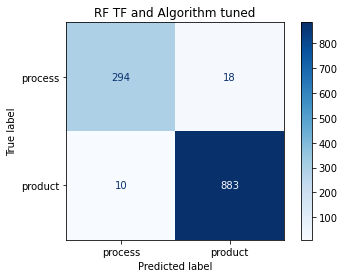

In [48]:
plot_conf = metrics.plot_confusion_matrix(rf_both_tune, X_test_tf_tune, y_test, values_format = 'n',
                                   cmap=plt.cm.Blues, display_labels = ['process' , 'product', 'use claim'] )
title = 'RF TF and Algorithm tuned'
plot_conf.ax_.set_title(title)

In [49]:
random_search_rf.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

In [60]:
MAE_weighted(rf_both_tune_pred_test, test_db, binary_class = 'Yes')

'weighted-MAE is 0.003498269118210207'

In [58]:
results_score.iloc[5]

Model           RF TF and Algorithm tuned
Data                                 Test
Precision                        0.980022
Recall                           0.988802
Specificity                      0.942308
F1-score                         0.984392
Accuracy                         0.976763
Bal Accuracy                     0.965555
AUC                              0.965555
Name: 0, dtype: object

In [62]:
#save the model
with open(ospath('~/code_final_project/Z_Best_models_saved/Claims/Best_Binary_model.pickle.pickle'), 'wb') as model:
    pickle.dump(rf_both_tune, model)
    
#save tf-df fitted vectorizer to use for the best model
with open(ospath('~/code_final_project/Z_Best_models_saved/Claims/Best_tf_idf_for_Binary_model.pickle'), 'wb') as model:
    pickle.dump(tfidf_rand, model)